<a href="https://colab.research.google.com/github/poojamahajan0712/EVA/blob/master/S11_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## S11 - Assignment 

Assignment: 

Write a code which
uses this new ResNet Architecture for Cifar10:<br>
PrepLayer - Conv 3x3 s1, p1) >> BN >> RELU [64k]<br>
Layer1 -<br>
X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k]<br>
R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k] <br>
Add(X, R1)<br>
Layer 2 -<br>
Conv 3x3 [256k]<br>
MaxPooling2D<br>
BN<br>
ReLU<br>
Layer 3 -<br>
X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k]<br>
R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k]<br>
Add(X, R2)<br>
MaxPooling with Kernel Size 4<br>
FC Layer <br>
SoftMax<br>

Uses One Cycle Policy such that:<br>
Total Epochs = 24<br>
Max at Epoch = 5<br>
LRMIN = FIND<br>
LRMAX = FIND<br>
NO Annihilation<br>
Uses this transform -RandomCrop 32, 32 (after padding of 4) >> FlipLR >> Followed by CutOut(8, 8)<br>
Batch size = 512<br>
Target Accuracy: 90%. <br>

In [0]:
%matplotlib inline
#!pip install albumentations==0.4.5
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from PIL import Image

from load_data_cifar10 import dataload
from util1 import *
import model3
#import gradcam
from train_version1 import train
from new_test1 import test
from a4 import album_train,album_test
#from visualize_v1 import VisualizeCam




In [0]:

    
trainloader,testloader,classes =dataload(train_transform=album_train(),test_transorm=album_test(),bat_size=512)


Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  car   car   car   car


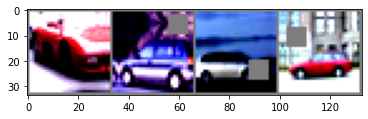

In [0]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4],padding=1))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [0]:

device = which_device()
net = model3.Net().to(device)
show_model_summary(net, device, (3,32,32))




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
           Conv2d-13          [-1, 256, 16, 16]         294,912
        MaxPool2d-14            [-1, 25

 **Define a Loss function and optimizer** 


**Training and Testing**





***Using StepLR to change Learning rate after every 5 iterations and compare train and test accuracies ***


In [0]:


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

#scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=24, pct_start=0.2)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)
def run():
  train_accs,test_losses,test_accs,pred_wrong_t,true_wrong_t,image_t=([] for i in range(6))
  lr=[]
  n=40
  for epoch in range(n):
      print("EPOCH:", epoch+1)
      train(net, device, trainloader, criterion, optimizer, epoch,train_accs)
      test((epoch==(n-1)),net, device, testloader, criterion, classes, test_losses, test_accs,pred_wrong_t,true_wrong_t,image_t)
      
      #lr.append(optimizer['lr'])
      
      print(scheduler.get_lr())
      lr.append(scheduler.get_lr())
      scheduler.step(epoch)

  return(train_accs,test_accs,pred_wrong_t,true_wrong_t,image_t,lr)
 

train_accs,test_accs,pred_wrong_t,true_wrong_t,image_t,lr=run()

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0046, Accuracy: 1355/10000 (13.55%)

[0.05]
EPOCH: 2


Loss=2.0624890327453613 Batch_id=97 Accuracy=15.30: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0041, Accuracy: 2279/10000 (22.79%)

[0.05]
EPOCH: 3


Loss=1.7767508029937744 Batch_id=97 Accuracy=28.58: 100%|██████████| 98/98 [01:40<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0034, Accuracy: 3488/10000 (34.88%)

[0.05]
EPOCH: 4


Loss=1.6760802268981934 Batch_id=97 Accuracy=36.27: 100%|██████████| 98/98 [01:41<00:00,  1.03s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0032, Accuracy: 4079/10000 (40.79%)

[0.05]
EPOCH: 5


Loss=1.457137107849121 Batch_id=97 Accuracy=42.71: 100%|██████████| 98/98 [01:37<00:00,  1.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 4699/10000 (46.99%)

[0.05]
EPOCH: 6


Loss=1.3828109502792358 Batch_id=97 Accuracy=47.50: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0027, Accuracy: 5237/10000 (52.37%)

[0.05]
EPOCH: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0025, Accuracy: 5449/10000 (54.49%)

[0.024499999999999997]
EPOCH: 8


Loss=1.2935186624526978 Batch_id=97 Accuracy=54.39: 100%|██████████| 98/98 [01:40<00:00,  1.03s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0024, Accuracy: 5696/10000 (56.96%)

[0.034999999999999996]
EPOCH: 9


Loss=1.158869743347168 Batch_id=97 Accuracy=57.36: 100%|██████████| 98/98 [01:37<00:00,  1.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0022, Accuracy: 6048/10000 (60.48%)

[0.034999999999999996]
EPOCH: 10


Loss=1.076658844947815 Batch_id=97 Accuracy=59.27: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0021, Accuracy: 6161/10000 (61.61%)

[0.034999999999999996]
EPOCH: 11


Loss=1.0652718544006348 Batch_id=97 Accuracy=62.06: 100%|██████████| 98/98 [01:40<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0020, Accuracy: 6495/10000 (64.95%)

[0.034999999999999996]
EPOCH: 12


Loss=0.9856522083282471 Batch_id=97 Accuracy=64.73: 100%|██████████| 98/98 [01:41<00:00,  1.03s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0019, Accuracy: 6595/10000 (65.95%)

[0.01715]
EPOCH: 13


Loss=0.9001880884170532 Batch_id=97 Accuracy=66.37: 100%|██████████| 98/98 [01:37<00:00,  1.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0018, Accuracy: 6795/10000 (67.95%)

[0.024499999999999997]
EPOCH: 14


Loss=0.8842641711235046 Batch_id=97 Accuracy=67.69: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0018, Accuracy: 6841/10000 (68.41%)

[0.024499999999999997]
EPOCH: 15


Loss=0.9173852801322937 Batch_id=97 Accuracy=68.64: 100%|██████████| 98/98 [01:40<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0018, Accuracy: 6796/10000 (67.96%)

[0.024499999999999997]
EPOCH: 16


Loss=0.9226030707359314 Batch_id=97 Accuracy=69.80: 100%|██████████| 98/98 [01:40<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0017, Accuracy: 7091/10000 (70.91%)

[0.024499999999999997]
EPOCH: 17


  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0016, Accuracy: 7271/10000 (72.71%)

[0.012004999999999997]
EPOCH: 18


Loss=0.7279301285743713 Batch_id=97 Accuracy=72.94: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0015, Accuracy: 7274/10000 (72.74%)

[0.017149999999999995]
EPOCH: 19


Loss=0.8058642148971558 Batch_id=97 Accuracy=73.33: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0015, Accuracy: 7319/10000 (73.19%)

[0.017149999999999995]
EPOCH: 20


Loss=0.8323908448219299 Batch_id=97 Accuracy=73.95: 100%|██████████| 98/98 [01:40<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0015, Accuracy: 7321/10000 (73.21%)

[0.017149999999999995]
EPOCH: 21


Loss=0.7334109544754028 Batch_id=97 Accuracy=74.96: 100%|██████████| 98/98 [01:37<00:00,  1.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0015, Accuracy: 7467/10000 (74.67%)

[0.017149999999999995]
EPOCH: 22


Loss=0.6928640604019165 Batch_id=97 Accuracy=76.23: 100%|██████████| 98/98 [01:38<00:00,  1.00s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0014, Accuracy: 7538/10000 (75.38%)

[0.008403499999999998]
EPOCH: 23


Loss=0.6742280125617981 Batch_id=97 Accuracy=76.57: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0013, Accuracy: 7679/10000 (76.79%)

[0.012004999999999998]
EPOCH: 24


Loss=0.6827101111412048 Batch_id=97 Accuracy=77.31: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0014, Accuracy: 7598/10000 (75.98%)

[0.012004999999999998]
EPOCH: 25


Loss=0.6949855089187622 Batch_id=97 Accuracy=77.82: 100%|██████████| 98/98 [01:37<00:00,  1.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0014, Accuracy: 7622/10000 (76.22%)

[0.012004999999999998]
EPOCH: 26


Loss=0.5793308615684509 Batch_id=97 Accuracy=78.40: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0014, Accuracy: 7678/10000 (76.78%)

[0.012004999999999998]
EPOCH: 27


Loss=0.5878632068634033 Batch_id=97 Accuracy=79.15: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0013, Accuracy: 7767/10000 (77.67%)

[0.005882449999999998]
EPOCH: 28


Loss=0.554643988609314 Batch_id=97 Accuracy=79.66: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0013, Accuracy: 7825/10000 (78.25%)

[0.008403499999999998]
EPOCH: 29


Loss=0.5224409103393555 Batch_id=97 Accuracy=80.12: 100%|██████████| 98/98 [01:37<00:00,  1.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0013, Accuracy: 7826/10000 (78.26%)

[0.008403499999999998]
EPOCH: 30


Loss=0.6380390524864197 Batch_id=97 Accuracy=80.42: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0012, Accuracy: 7887/10000 (78.87%)

[0.008403499999999998]
EPOCH: 31


Loss=0.5730774998664856 Batch_id=97 Accuracy=80.62: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0012, Accuracy: 7878/10000 (78.78%)

[0.008403499999999998]
EPOCH: 32


Loss=0.5254479646682739 Batch_id=97 Accuracy=81.52: 100%|██████████| 98/98 [01:40<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0012, Accuracy: 7891/10000 (78.91%)

[0.004117714999999998]
EPOCH: 33


Loss=0.5839158892631531 Batch_id=97 Accuracy=81.81: 100%|██████████| 98/98 [01:37<00:00,  1.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0012, Accuracy: 7854/10000 (78.54%)

[0.005882449999999998]
EPOCH: 34


Loss=0.49247804284095764 Batch_id=97 Accuracy=81.77: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0012, Accuracy: 7925/10000 (79.25%)

[0.005882449999999998]
EPOCH: 35


Loss=0.5211052298545837 Batch_id=97 Accuracy=82.18: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0012, Accuracy: 7974/10000 (79.74%)

[0.005882449999999998]
EPOCH: 36


Loss=0.48365697264671326 Batch_id=97 Accuracy=82.22: 100%|██████████| 98/98 [01:41<00:00,  1.03s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0012, Accuracy: 7937/10000 (79.37%)

[0.005882449999999998]
EPOCH: 37


Loss=0.36664053797721863 Batch_id=97 Accuracy=83.01: 100%|██████████| 98/98 [01:37<00:00,  1.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0012, Accuracy: 7969/10000 (79.69%)

[0.0028824004999999987]
EPOCH: 38


Loss=0.4530209004878998 Batch_id=97 Accuracy=83.21: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0012, Accuracy: 7990/10000 (79.90%)

[0.004117714999999998]
EPOCH: 39


Loss=0.47351351380348206 Batch_id=97 Accuracy=83.39: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0012, Accuracy: 7945/10000 (79.45%)

[0.004117714999999998]
EPOCH: 40


Loss=0.46599993109703064 Batch_id=97 Accuracy=83.76: 100%|██████████| 98/98 [01:40<00:00,  1.02s/it]


Test set: Average loss: 0.0012, Accuracy: 8041/10000 (80.41%)

[0.004117714999999998]


Text(0.5, 1.0, 'Test Accuracy vs LR')

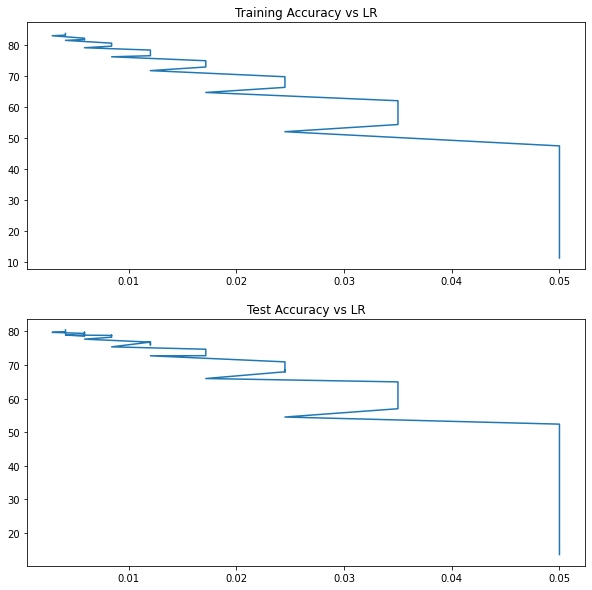

In [0]:
fig, axs = plt.subplots(2,1,figsize=(10,10))
axs[0].plot(lr,train_accs)
axs[0].set_title("Training Accuracy vs LR")
axs[1].plot(lr,test_accs)
axs[1].set_title("Test Accuracy vs LR")


In [0]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=24, pct_start=0.2,final_div_factor=100.0)

def run():
  train_accs,test_losses,test_accs,pred_wrong_t,true_wrong_t,image_t=([] for i in range(6))
  #lr=[]
  n=24
  for epoch in range(n):
      print("EPOCH:", epoch+1)
      train(net, device, trainloader, criterion, optimizer, epoch,train_accs,scheduler)
      test((epoch==(n-1)),net, device, testloader, criterion, classes, test_losses, test_accs,pred_wrong_t,true_wrong_t,image_t)
      
      #lr.append(optimizer['lr'])
      #print(scheduler.get_lr())
      #lr.append(scheduler.get_lr())
      #scheduler.step(epoch)

  return(train_accs,test_accs,pred_wrong_t,true_wrong_t,image_t)
 

train_accs,test_accs,pred_wrong_t,true_wrong_t,image_t=run()

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.242572546005249 Batch_id=97 Accuracy=36.75: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0026, Accuracy: 5230/10000 (52.30%)

EPOCH: 2


Loss=1.1385431289672852 Batch_id=97 Accuracy=57.42: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0024, Accuracy: 5819/10000 (58.19%)

EPOCH: 3


Loss=0.8439438343048096 Batch_id=97 Accuracy=66.42: 100%|██████████| 98/98 [00:24<00:00,  4.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0018, Accuracy: 6810/10000 (68.10%)

EPOCH: 4


Loss=0.9032596349716187 Batch_id=97 Accuracy=71.78: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0018, Accuracy: 7058/10000 (70.58%)

EPOCH: 5


Loss=0.7041204571723938 Batch_id=97 Accuracy=76.00: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0015, Accuracy: 7488/10000 (74.88%)

EPOCH: 6


Loss=0.5853747129440308 Batch_id=97 Accuracy=79.98: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0011, Accuracy: 8128/10000 (81.28%)

EPOCH: 7


Loss=0.5638499855995178 Batch_id=97 Accuracy=82.97: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0011, Accuracy: 8135/10000 (81.35%)

EPOCH: 8


Loss=0.44609832763671875 Batch_id=97 Accuracy=84.34: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0011, Accuracy: 8166/10000 (81.66%)

EPOCH: 9


Loss=0.43441540002822876 Batch_id=97 Accuracy=86.29: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0011, Accuracy: 8196/10000 (81.96%)

EPOCH: 10


Loss=0.42260605096817017 Batch_id=97 Accuracy=88.13: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0011, Accuracy: 8286/10000 (82.86%)

EPOCH: 11


Loss=0.33274295926094055 Batch_id=97 Accuracy=89.40: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0011, Accuracy: 8321/10000 (83.21%)

EPOCH: 12


Loss=0.28921017050743103 Batch_id=97 Accuracy=90.63: 100%|██████████| 98/98 [00:24<00:00,  3.92it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0010, Accuracy: 8414/10000 (84.14%)

EPOCH: 13


Loss=0.2407514452934265 Batch_id=97 Accuracy=91.79: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 83 %
Accuracy of   car : 87 %
Accuracy of  bird : 70 %
Accuracy of   cat : 62 %
Accuracy of  deer : 83 %
Accuracy of   dog : 80 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 85 %
Accuracy of truck : 62 %

Test set: Average loss: 0.0009, Accuracy: 8584/10000 (85.84%)

EPOCH: 14


Loss=0.18556512892246246 Batch_id=97 Accuracy=92.94: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 87 %
Accuracy of   car : 100 %
Accuracy of  bird : 66 %
Accuracy of   cat : 66 %
Accuracy of  deer : 83 %
Accuracy of   dog : 54 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 87 %

Test set: Average loss: 0.0009, Accuracy: 8546/10000 (85.46%)

EPOCH: 15


Loss=0.16486965119838715 Batch_id=97 Accuracy=93.91: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 90 %
Accuracy of   car : 75 %
Accuracy of  bird : 61 %
Accuracy of   cat : 88 %
Accuracy of  deer : 91 %
Accuracy of   dog : 85 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0009, Accuracy: 8667/10000 (86.67%)

EPOCH: 16


Loss=0.13495783507823944 Batch_id=97 Accuracy=94.81: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 62 %
Accuracy of   car : 92 %
Accuracy of  bird : 100 %
Accuracy of   cat : 50 %
Accuracy of  deer : 50 %
Accuracy of   dog : 75 %
Accuracy of  frog : 88 %
Accuracy of horse : 66 %
Accuracy of  ship : 100 %
Accuracy of truck : 83 %

Test set: Average loss: 0.0010, Accuracy: 8527/10000 (85.27%)

EPOCH: 17


Loss=0.15344686806201935 Batch_id=97 Accuracy=95.44: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 77 %
Accuracy of  deer : 100 %
Accuracy of   dog : 100 %
Accuracy of  frog : 87 %
Accuracy of horse : 80 %
Accuracy of  ship : 87 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0009, Accuracy: 8679/10000 (86.79%)

EPOCH: 18


Loss=0.12987560033798218 Batch_id=97 Accuracy=96.36: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 62 %
Accuracy of  deer : 87 %
Accuracy of   dog : 77 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 77 %
Accuracy of truck : 87 %

Test set: Average loss: 0.0009, Accuracy: 8699/10000 (86.99%)

EPOCH: 19


Loss=0.09164568781852722 Batch_id=97 Accuracy=96.77: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 75 %
Accuracy of   cat : 100 %
Accuracy of  deer : 100 %
Accuracy of   dog : 83 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 88 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0009, Accuracy: 8702/10000 (87.02%)

EPOCH: 20


Loss=0.06431110948324203 Batch_id=97 Accuracy=97.32: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 100 %
Accuracy of  bird : 85 %
Accuracy of   cat : 66 %
Accuracy of  deer : 91 %
Accuracy of   dog : 83 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 80 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0008, Accuracy: 8794/10000 (87.94%)

EPOCH: 21


Loss=0.08583866059780121 Batch_id=97 Accuracy=97.72: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 60 %
Accuracy of  deer : 100 %
Accuracy of   dog : 72 %
Accuracy of  frog : 85 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0008, Accuracy: 8838/10000 (88.38%)

EPOCH: 22


Loss=0.08190028369426727 Batch_id=97 Accuracy=98.15: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 71 %
Accuracy of   car : 100 %
Accuracy of  bird : 75 %
Accuracy of   cat : 60 %
Accuracy of  deer : 87 %
Accuracy of   dog : 77 %
Accuracy of  frog : 100 %
Accuracy of horse : 88 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0008, Accuracy: 8840/10000 (88.40%)

EPOCH: 23


Loss=0.068789541721344 Batch_id=97 Accuracy=98.24: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 90 %
Accuracy of   car : 100 %
Accuracy of  bird : 85 %
Accuracy of   cat : 57 %
Accuracy of  deer : 100 %
Accuracy of   dog : 75 %
Accuracy of  frog : 90 %
Accuracy of horse : 100 %
Accuracy of  ship : 85 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0008, Accuracy: 8840/10000 (88.40%)

EPOCH: 24


Loss=0.06760523468255997 Batch_id=97 Accuracy=98.28: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]



Accuracy of plane : 75 %
Accuracy of   car : 100 %
Accuracy of  bird : 85 %
Accuracy of   cat : 66 %
Accuracy of  deer : 66 %
Accuracy of   dog : 100 %
Accuracy of  frog : 90 %
Accuracy of horse : 88 %
Accuracy of  ship : 100 %
Accuracy of truck : 83 %

Test set: Average loss: 0.0008, Accuracy: 8851/10000 (88.51%)



In [0]:
print(int(pred_wrong_t[0]))

8


'extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())\nfig.savefig(\'Accuracy_S6.png\', bbox_inches=extent.expanded(1.1, 1.2))\nfiles.download("Accuracy_S6.png") '

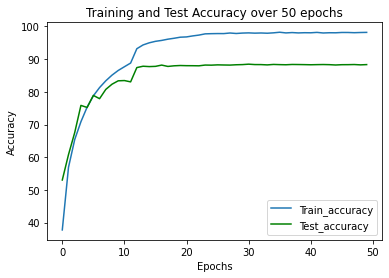

In [0]:
from google.colab import files
plt.plot(train_accs[:], label="Train_accuracy")
plt.plot(test_accs[:], color="green", label="Test_accuracy")
plt.title("Training and Test Accuracy over 50 epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

'''extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('Accuracy_S6.png', bbox_inches=extent.expanded(1.1, 1.2))
files.download("Accuracy_S6.png") '''


GroundTruth:   frog truck  frog  deer


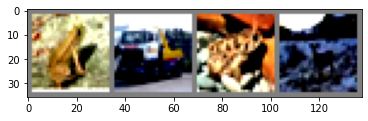

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = VisualizeCam(net,classes, target_layers)

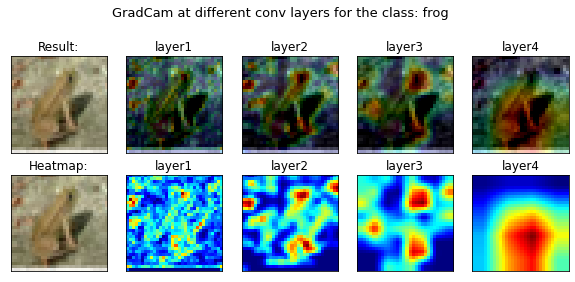

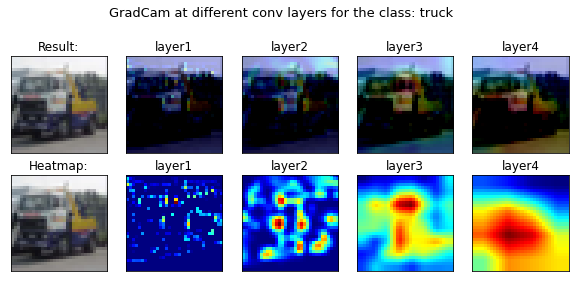

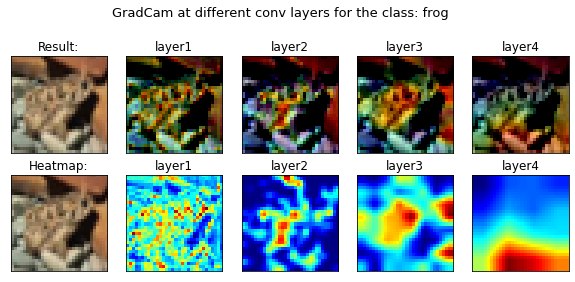

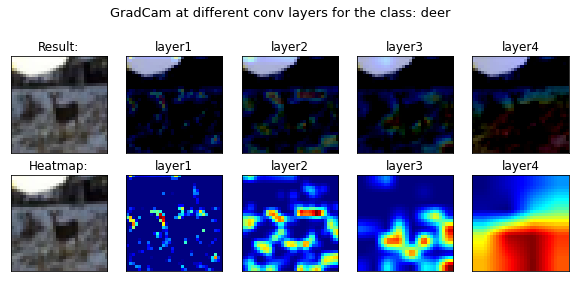

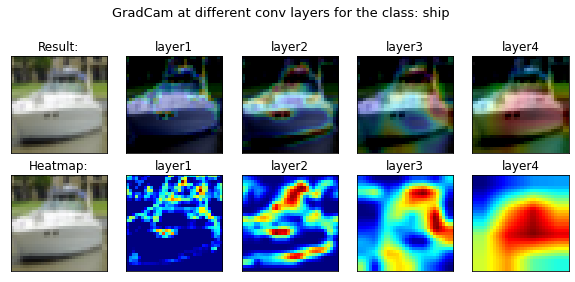

In [0]:
incorrect_pred_imgs = []
for i in range(25):
  incorrect_pred_imgs.append(torch.as_tensor(images[i]))
viz_cam(torch.stack(incorrect_pred_imgs), target_layers, metric="incorrect")

Okay, now let us see what the neural network thinks these examples above are:
The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:


In [0]:
images=images.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog truck  frog  deer


The results seem pretty good.

Let us look at how the network performs on the whole dataset.

